# Mask R-CNN - Inspect ScrANTon Trained Model

In [1]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
#import skimage.transform

vram = 4

#tf.debugging.set_log_device_placement(True)
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
if gpus:
    # Restrict TensorFlow to only allocate 1GB * 2 of memory on the first GPU
    try:
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0],
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024 * vram)])
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Virtual devices must be set before GPUs have been initialized
        print(e)
    
import warnings
warnings.filterwarnings('ignore')

# Root directory of the project
ROOT_DIR = os.path.abspath(r"/home/ant/Tracker/ScrANTonTracker/ScrANTonTrackerLAB/")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
import mrcnn.model as modellib
from mrcnn.model import log
from mrcnn.model import log2_graph

from PIL import Image
import imageio
from ants import ants

#%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Path to Ballon trained weights
# You can download this file from the Releases page
# https://github.com/matterport/Mask_RCNN/releases
# BALLON_WEIGHTS_PATH = r"/home/ant/TITANlogs/TRAINEDFULLANTS824.h5" #TRAINEDFULLANTS.h5"  # TODO: update this path
# MODEL_DIR = BALLON_WEIGHTS_PATH
# print(BALLON_WEIGHTS_PATH)

/home/ant/anaconda3/envs/py37/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/ant/anaconda3/envs/py37/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/ant/anaconda3/envs/py37/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/ant/anaconda3/envs/py37/lib/python3.7/site-packages/ten

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
1 Physical GPUs, 1 Logical GPUs


Using TensorFlow backend.


## Configurations

In [2]:
AntConfig = ants.AntConfig()
ANT_DIR = os.path.join(ROOT_DIR, "data")

In [3]:
class InferenceConfig(AntConfig.__class__):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    #DETECTION_MIN_CONFIDENCE = .7
    IMAGE_RESIZE_MODE = "square"
    IMAGE_MIN_DIM = 1024
    IMAGE_MAX_DIM = 2048
    #IMAGE_MIN_SCALE = 2
    #MEAN_PIXEL = np.array([123.7, 115, 103.9])

AntConfig = InferenceConfig()
AntConfig.display()
#config.gpu_options.allow_growth = True


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.6
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  2048
IMAGE_META_SIZE                17
IMAGE_MIN_DIM                  1024
IMAGE_MIN_SCALE                1
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [2048 2048    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE        

## Notebook Preferences

In [4]:
DEVICE = "/gpu:0"  # /cpu:0 or /gpu:0
TEST_MODE = "inference"

def get_ax(rows=1, cols=1, size=16):
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

## Load Validation Dataset

In [5]:
# Load validation dataset
dataset = ants.AntDataset()
dataset.load_ant(ANT_DIR, "val")

# Must call before using the dataset
dataset.prepare()

print("Images: {}\nClasses: {}".format(len(dataset.image_ids), dataset.class_names))

loading annotations into memory...
Done (t=0.15s)
creating index...
index created!
Images: 681
Classes: ['BG', 'Full Ant', 'Abdomen', 'Thorax', 'Head']


## Load Model

In [6]:
# Create model in inference mode

#config.gpu_options.allow_growth = True

with tf.device(DEVICE):
    model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR,
                              config=AntConfig)
    
weights_path = r"/home/ant/TITANlogs/TRAINEDFULLANTS824.h5" #TRAINEDFULLANTS.h5"
print("Loading weights ", weights_path)
model.load_weights(weights_path, by_name=True)



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
box_ind is deprecated, use box_indices instead


Instructions for updating:
Use `tf.cast` instead.
Loading weights  /home/ant/TITANlogs/TRAINEDFULLANTS824.h5


## Run Detection

Processing 1 images
image                    shape: (836, 1254, 3)        min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 2048, 2048, 3)    min: -123.70000  max:  149.10000  float64
image_metas              shape: (1, 17)               min:    0.00000  max: 2048.00000  float64
anchors                  shape: (1, 1047552, 4)       min:   -0.17686  max:    1.14560  float32
Detection took  1.4111111164093018 seconds.
Visualization took  4.248892784118652 seconds.


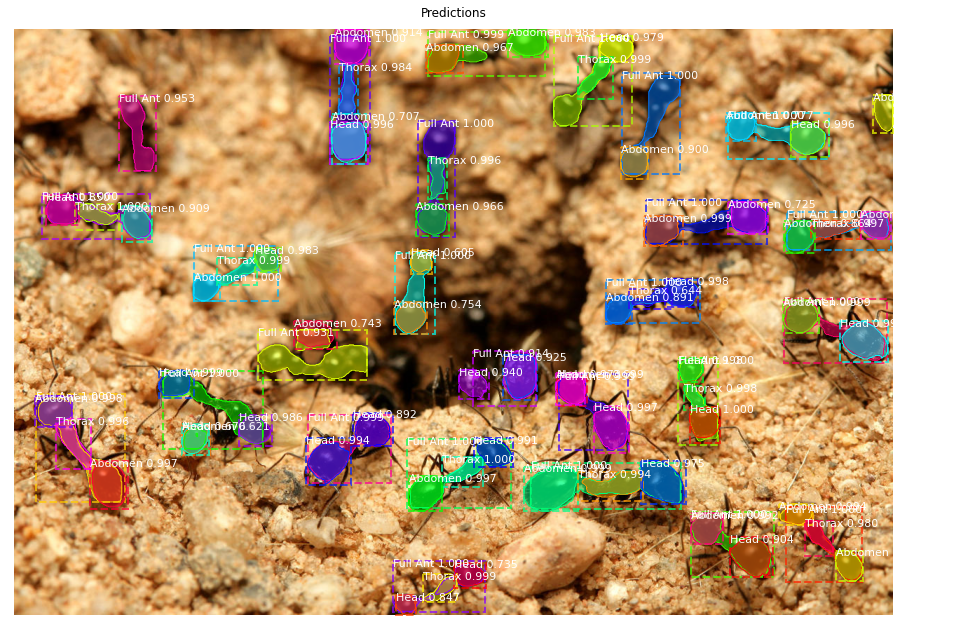

In [8]:
#image_id = random.choice(dataset.image_ids)

#image_id = 82
#image_id = dataset.image_ids[37,186,297,471,82,509,583,362,379,495?]
#print(image_id)

#image, image_meta, gt_class_id, gt_bbox, gt_mask =\
#    modellib.load_image_gt(dataset, config, image_id, use_mini_mask=False)
#info = dataset.image_info[image_id]
#print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id, 
#                                       dataset.image_reference(image_id)))

image1 = imageio.imread(r"/home/ant/Tracker/ScrANTonTracker/ScrANTonTrackerLAB/data/images/cjxlw3v4l0e4o0794ly8dpdzu.jpg")
image2 = imageio.imread(r"/home/ant/Tracker/ScrANTonTracker/ScrANTonTrackerLAB/data/images/cjx0pyistpe3q0844tqjgdotb.jpg")
# Run object detection

startdetect = time.time()
results = model.detect([image1], verbose=1)
enddetect = time.time()
print("Detection took ", enddetect - startdetect, "seconds.")

# Display results
ax = get_ax(1)
r = results[0]

startvis = time.time()
visualize.display_instances(image1, r['rois'], r['masks'], r['class_ids'], 
                            dataset.class_names, r['scores'], ax=ax, title="Predictions")
endvis = time.time()
print("Visualization took ", endvis - startvis, "seconds.")
#log("gt_class_id", gt_class_id)
#log("gt_bbox", gt_bbox)
#log("gt_mask", gt_mask)